In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.impute import KNNImputer
from sklearn.exceptions import UndefinedMetricWarning
import warnings
import seaborn as sns

In [127]:
# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

Step1: for this assignment you can provide your own data. The data must be pulled/scraped from online resources (as covered in other courses) to obtain full credit of this step. For example, you can scrape tweeter data or Kijiji data etc.

In [128]:
# Step 1. Data Scrapping

In [129]:
#  1.1 Data Collection

In [130]:
df=pd.read_csv('https://raw.githubusercontent.com/umeshkhatiwada13/Datasets/main/kijiji_rental_ads_4106.csv')
df1=df.copy()

Step 2: proceed with initial steps of data wrangling and properly name/label/explain the activities in this (and all other) steps. Use the data you provided in step 1 and apply data wrangling steps including but not limited to data cleaning, formatting and structuring, validating etc.

## Step 2 : Data Description and Wrangling

2.1 Understanding the data

In [131]:
df.shape

(4106, 23)

In [132]:
df.head(2)

,Title,Price($),Address,Date Posted,Building Type,Bedrooms,Bathrooms,Utilities,Wi-Fi and More,Parking Included,...,Size (sqft),Furnished,Air Conditioning,Personal Outdoor Space,Smoking Permitted,Appliances,Amenities,Description,Visit Counter,url
0,6020 Bathurst Street - Valencia Towers Apartme...,3209.0,"6020 Bathurst Street, Toronto, ON, M2R 1Z8",2024-02-24 23:30:00,Apartment,2,1,NaN,Not Included,0,...,912,No,No,Not Included,No,Fridge / Freezer,Elevator in Building,Valencia Towers is a student- and family-frien...,NaN,https://www.kijiji.ca/v-apartments-condos/city...
1,RENOVATED BACHELOR SUITE AVAILABLE! Lakeview ...,2000.0,"22 Close Avenue, Toronto, ON, M6K 2V2",2024-03-14 00:09:49,Apartment,Bachelor/Studio,1,"Hydro_No,Heat_No,Water_Yes",Not Included,0,...,445,No,No,Balcony,No,"Laundry (In Building), Fridge / Freezer","Gym, Pool, Storage Space, Elevator in Building","Bachelors, 1 Bath, Recently Renovated Kitchen ...",NaN,https://www.kijiji.ca/v-apartments-condos/city...


In [133]:
df.tail(2)

,Title,Price($),Address,Date Posted,Building Type,Bedrooms,Bathrooms,Utilities,Wi-Fi and More,Parking Included,...,Size (sqft),Furnished,Air Conditioning,Personal Outdoor Space,Smoking Permitted,Appliances,Amenities,Description,Visit Counter,url
4104,Basement Apartment Rental - Newly Renovated,2100.0,"Scarborough, ON M1K 2T9",NaN,Basement,1 + Den,1,"Hydro_Yes,Heat_Yes,Water_Yes",Internet,1,...,"1,000",No,Yes,Not Included,No,"Laundry (In Building), Fridge / Freezer",NaN,Basement Apartment Rental - Short term Rental ...,267 visits,https://www.kijiji.ca/v-apartments-condos/city...
4105,Spacious 2 Bedroom Apartment - North York -Wai...,2450.0,"50 Graydon Hall Drive, North York, ON, M3A 3A3",NaN,Apartment,2,1,"Hydro_Yes,Heat_Yes,Water_Yes",Not Included,0,...,Not Available,No,No,Balcony,Yes,"Laundry (In Building), Dishwasher, Fridge / Fr...",NaN,Style 2F - waiting list in effect - please cal...,NaN,https://www.kijiji.ca/v-apartments-condos/city...


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106 entries, 0 to 4105
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   4099 non-null   object 
 1   Price($)                3850 non-null   float64
 2   Address                 4094 non-null   object 
 3   Date Posted             3498 non-null   object 
 4   Building Type           3081 non-null   object 
 5   Bedrooms                3081 non-null   object 
 6   Bathrooms               3081 non-null   object 
 7   Utilities               2138 non-null   object 
 8   Wi-Fi and More          3081 non-null   object 
 9   Parking Included        3081 non-null   object 
 10  Agreement Type          3081 non-null   object 
 11  Move-In Date            2008 non-null   object 
 12  Pet Friendly            3759 non-null   object 
 13  Size (sqft)             3083 non-null   object 
 14  Furnished               4059 non-null   

In [135]:
df.describe(percentiles=[0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99]).round(1)

,Price($)
count,3850.0
mean,2605.8
std,18485.3
min,20.0
1%,400.0
10%,950.0
20%,1450.0
30%,1800.0
40%,1975.0
50%,2184.5


2.2 Data Wrangling

2.2.1 Handling Inconsistent Data

In [136]:
# Use regular expressions to keep only digits or NaN for visit counter column
df['Visit Counter'] = df['Visit Counter'].apply(lambda x: re.sub(r'\D', '', str(x)))

# Convert the column to integer type
df['Visit Counter'] = pd.to_numeric(df['Visit Counter'], errors='coerce', downcast='integer')

In [137]:
df['Visit Counter'].min()
df['Visit Counter'].max()


9452.0

In [138]:
# Mapping of utilities string values to integer values
mapping = {
    'Hydro_Yes,Heat_Yes,Water_Yes': 3,
    'Hydro_Yes,Heat_No,Water_Yes': 2,
    'Hydro_No,Heat_Yes,Water_Yes': 2,
    'Hydro_Yes,Heat_Yes,Water_No': 2,
    'Hydro_Yes,Heat_No,Water_No': 1,
    'Hydro_No,Heat_No,Water_Yes': 1,
    'Hydro_No,Heat_Yes,Water_No': 1
}

# Replace values in the 'Utilities' column using the mapping
df['Utilities'] = df['Utilities'].replace(mapping)


In [139]:
df['Size (sqft)'] = pd.to_numeric(df['Size (sqft)'],errors='coerce')
# Replace NaN values with 0
df['Size (sqft)'].fillna(0, inplace=True)

2.2.2 Handling Missing Values

In [140]:
df.isnull().sum()

Title                        7
Price($)                   256
Address                     12
Date Posted                608
Building Type             1025
Bedrooms                  1025
Bathrooms                 1025
Utilities                 1968
Wi-Fi and More            1025
Parking Included          1025
Agreement Type            1025
Move-In Date              2098
Pet Friendly               347
Size (sqft)                  0
Furnished                   47
Air Conditioning          1025
Personal Outdoor Space    1025
Smoking Permitted         1025
Appliances                1535
Amenities                 2510
Description                186
Visit Counter             1677
url                          0
dtype: int64

In [141]:
# Looking at the null percentage of each columns
print((df.isnull().mean() * 100).round(2).astype(str) + '%')

Title                      0.17%
Price($)                   6.23%
Address                    0.29%
Date Posted               14.81%
Building Type             24.96%
Bedrooms                  24.96%
Bathrooms                 24.96%
Utilities                 47.93%
Wi-Fi and More            24.96%
Parking Included          24.96%
Agreement Type            24.96%
Move-In Date               51.1%
Pet Friendly               8.45%
Size (sqft)                 0.0%
Furnished                  1.14%
Air Conditioning          24.96%
Personal Outdoor Space    24.96%
Smoking Permitted         24.96%
Appliances                37.38%
Amenities                 61.13%
Description                4.53%
Visit Counter             40.84%
url                         0.0%
dtype: object


In [142]:
df = df[(df['Building Type'].notna() & (df['Building Type'] != '') & (df['Building Type'] != 'Not Available'))]

df.shape

(3081, 23)

In [143]:

"""those rows with no price were traced manually and found that those were the urls already removed from kijiji from url extraction time to actual
data scrape time hence we are dropping those rows"""

df.dropna(subset=['Price($)'], inplace=True)

<ipython-input-143-a796dca310fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Price($)'], inplace=True)


In [144]:
# imputing missing values for visit counter column
df['Visit Counter'] = KNNImputer(n_neighbors=5).fit_transform(df[['Visit Counter']])
df['Visit Counter'] = df['Visit Counter'].astype(int)

In [145]:
# df['Utilities'] = KNNImputer(n_neighbors=5).fit_transform(df[['Utilities']])
imputer = KNNImputer(n_neighbors=3)
df['Utilities'] = imputer.fit_transform(df[['Utilities']])
df['Utilities'] = df['Utilities'].astype(int)
df['Utilities'].unique()


array([2, 1, 3])

In [146]:
df['Agreement Type'] = df['Agreement Type'].replace('Not Available', 'Customizable')

In [147]:
df.drop(columns=['Amenities'], inplace=True)

In [148]:
df.drop('Appliances', axis=1, inplace=True)

In [149]:
# df.drop('Date Posted', axis=1, inplace=True)


In [150]:
df.drop('Move-In Date', axis=1, inplace=True)

**2.2.3 Removing Duplicates**

In [151]:
df['Utilities'].unique()

array([2, 1, 3])

In [152]:
df['Utilities'].unique()

array([2, 1, 3])

In [153]:
df.head()

,Title,Price($),Address,Date Posted,Building Type,Bedrooms,Bathrooms,Utilities,Wi-Fi and More,Parking Included,Agreement Type,Pet Friendly,Size (sqft),Furnished,Air Conditioning,Personal Outdoor Space,Smoking Permitted,Description,Visit Counter,url
0,6020 Bathurst Street - Valencia Towers Apartme...,3209.0,"6020 Bathurst Street, Toronto, ON, M2R 1Z8",2024-02-24 23:30:00,Apartment,2,1,2,Not Included,0,1 Year,Yes,912.0,No,No,Not Included,No,Valencia Towers is a student- and family-frien...,238,https://www.kijiji.ca/v-apartments-condos/city...
1,RENOVATED BACHELOR SUITE AVAILABLE! Lakeview ...,2000.0,"22 Close Avenue, Toronto, ON, M6K 2V2",2024-03-14 00:09:49,Apartment,Bachelor/Studio,1,1,Not Included,0,1 Year,Yes,445.0,No,No,Balcony,No,"Bachelors, 1 Bath, Recently Renovated Kitchen ...",238,https://www.kijiji.ca/v-apartments-condos/city...
2,50 Driftwood - Ruby Heights Apartment for Rent,2819.0,"50 Driftwood, Toronto, ON, M3N 2M6",2024-03-03 00:08:58,Apartment,2,1,2,Not Included,0,1 Year,Yes,904.0,No,No,Not Included,No,"Ruby Heights, located in the North York distri...",238,https://www.kijiji.ca/v-apartments-condos/city...
3,1 Bed Apartment Rent today,2519.0,"100 Parkway Forest Drive, Toronto, ON, M2J 1L6",2024-03-06 00:35:06,Apartment,1,1,2,Not Included,0,1 Year,Limited,665.0,No,No,Yard,Yes,"For a limited time, you can receive ONE MONTH ...",238,https://www.kijiji.ca/v-apartments-condos/city...
4,Brand New 2-bedroom Rental in North York! Yor...,2690.0,"1225 York Road, Toronto, ON, M3A 1Y4",2024-03-04 00:39:41,Apartment,2,1,2,Not Included,0,1 Year,Yes,0.0,No,Yes,Balcony,Yes,Realstar's ONE225 York Mills is North Yorks ne...,238,https://www.kijiji.ca/v-apartments-condos/city...


In [154]:
# df['Date Posted']

In [155]:
df['Date Posted'] = pd.to_datetime(df['Date Posted'], errors='coerce')

# Calculate the difference in days since today for non-NaN values
df['days_posted_ago'] = (pd.Timestamp.now() - df['Date Posted']).dt.days

# Replace NaN values with NaN (no change)
df['days_posted_ago'].fillna(pd.NA, inplace=True)

# If you want to convert negative values to 0 (since they are in the future)
df['days_posted_ago'] = df['days_posted_ago'].clip(lower=0)

# Convert the result to integer type
df['days_posted_ago'] = df['days_posted_ago'].astype('Int64')


In [156]:
df['days_posted_ago'].unique()

<IntegerArray>
[  20,    2,   13,   10,   12,   27,    3,    9,   21,   11,   16,    8,    4,
   24,    5,    1,   25,   33,   23,   14,   17,   15,   18,    6,    7,   19,
   22,   26,   28,   29,   30,   31,   32, <NA>]
Length: 34, dtype: Int64

In [157]:
mode_days_posted_ago = df['days_posted_ago'].mode()[0]

# Fill null values in 'days_posted_ago' with the mode
df['days_posted_ago'].fillna(mode_days_posted_ago, inplace=True)

# Convert the 'days_posted_ago' column to integer type
df['days_posted_ago'] = df['days_posted_ago'].astype(int)

In [158]:
count_utilities_in_description = df[df['Utilities'].isna() & df['Description'].str.contains('utilities included', case=False)].shape[0]
print(count_utilities_in_description)

0


In [159]:
# Filling 'Utilities' column where 'Description' contains 'utilities included' and 'Utilities' column is null
df.loc[df['Description'].str.contains('utilities included', case=False) & df['Utilities'].isna(), 'Utilities'] = 'Hydro_Yes,Heat_Yes,Water_Yes'


In [160]:
# Filter the DataFrame, dropping rows with NaN values in the 'Description' column
filtered_df = df.dropna(subset=['Description'])

# Filter further based on the condition
filtered_df = filtered_df[filtered_df['Description'].str.contains('utilities included', case=False)]

# Print the filtered DataFrame
# Print the lowercase version of the part after 'utilities included' in each description
print(filtered_df['Description'].apply(lambda x: x.lower()).str.split('utilities included').str[1])



14                                                       
15                                                       
16                                                       
21                                                       
22                                                       
                              ...                        
3938    .\nif you have a unit or know of a unit that i...
4031                     , not more than 3 people allowed
4033    . lots of natural light. lovely quiet building...
4052     (heat, a/c, water -no smoking, no pets, no su...
4104                                    - $2100 per month
Name: Description, Length: 252, dtype: object


In [161]:
#splitting into numeric and categorical dataframe
numeric_columns = df.select_dtypes(include=np.number).columns
categorical_columns = df.select_dtypes(exclude=np.number).columns

In [162]:
print(categorical_columns)

Index(['Title', 'Address', 'Date Posted', 'Building Type', 'Bedrooms',
       'Bathrooms', 'Utilities', 'Wi-Fi and More', 'Parking Included',
       'Agreement Type', 'Pet Friendly', 'Furnished', 'Air Conditioning',
       'Personal Outdoor Space', 'Smoking Permitted', 'Description', 'url'],
      dtype='object')


In [163]:
print(numeric_columns)

Index(['Price($)', 'Size (sqft)', 'Visit Counter', 'days_posted_ago'], dtype='object')


In [164]:
df['Agreement Type'].value_counts()

1 Year            2524
Month-to-month     318
Customizable        95
Name: Agreement Type, dtype: int64

In [165]:
# looking the unique values in dataframe
cols = ['Building Type', 'Bedrooms', 'Bathrooms',
       'Utilities', 'Wi-Fi and More', 'Parking Included', 'Agreement Type',
       'Pet Friendly', 'Furnished', 'Air Conditioning',
       'Personal Outdoor Space', 'Smoking Permitted']

for col in cols:
    unique_values = df[col].unique()
    print(f"\nUnique values for {col}: {unique_values}")



Unique values for Building Type: ['Apartment' 'Condo' 'Basement' 'House' 'Duplex/Triplex' 'Townhouse']

Unique values for Bedrooms: ['2' 'Bachelor/Studio' '1' '3' '2 + Den' '1 + Den' '3 + Den' '4' '5+'
 '4 + Den']

Unique values for Bathrooms: ['1' '1.5' '2' '2.5' '3' '6+']

Unique values for Utilities: [2 1 3]

Unique values for Wi-Fi and More: ['Not Included' 'Internet' 'Cable / TVInternet' 'Cable / TV']

Unique values for Parking Included: ['0' '1' '2' '3+']

Unique values for Agreement Type: ['1 Year' 'Month-to-month' 'Customizable']

Unique values for Pet Friendly: ['Yes' 'Limited' 'No']

Unique values for Furnished: ['No' 'Yes']

Unique values for Air Conditioning: ['No' 'Yes' 'Not Available']

Unique values for Personal Outdoor Space: ['Not Included' 'Balcony' 'Yard' 'YardBalcony']

Unique values for Smoking Permitted: ['No' 'Yes' 'Outdoors only']


In [166]:
print((df.isnull().mean() * 100).round(2).astype(str) + '%')


Title                       0.0%
Price($)                    0.0%
Address                     0.0%
Date Posted               12.39%
Building Type               0.0%
Bedrooms                    0.0%
Bathrooms                   0.0%
Utilities                   0.0%
Wi-Fi and More              0.0%
Parking Included            0.0%
Agreement Type              0.0%
Pet Friendly                0.0%
Size (sqft)                 0.0%
Furnished                   0.0%
Air Conditioning            0.0%
Personal Outdoor Space      0.0%
Smoking Permitted           0.0%
Description                5.62%
Visit Counter               0.0%
url                         0.0%
days_posted_ago             0.0%
dtype: object


In [167]:
df.shape

(2937, 21)

2.2.4 Data Formatting and Standardization

## Step 3: Exploratory Data Analysis (EDA)
  use proper plotting methods to demonstrate the distribution of various attributed (columns) in the data.

**3.1 Summary Statistics**

In [168]:
# Calculate summary statistics
summary_stats = df.describe()
print(summary_stats)

            Price($)  Size (sqft)  Visit Counter  days_posted_ago
count    2937.000000  2937.000000    2937.000000      2937.000000
mean     2542.511066   444.879128     238.222676         9.511406
std      5545.154903   338.513978     247.497218         8.421255
min        99.000000     0.000000       0.000000         1.000000
25%      1950.000000     0.000000     142.000000         2.000000
50%      2300.000000   548.000000     238.000000         6.000000
75%      2700.000000   710.000000     238.000000        15.000000
max    245000.000000   998.000000    5580.000000        33.000000


**3.2 Distribution of Numeric Variables**

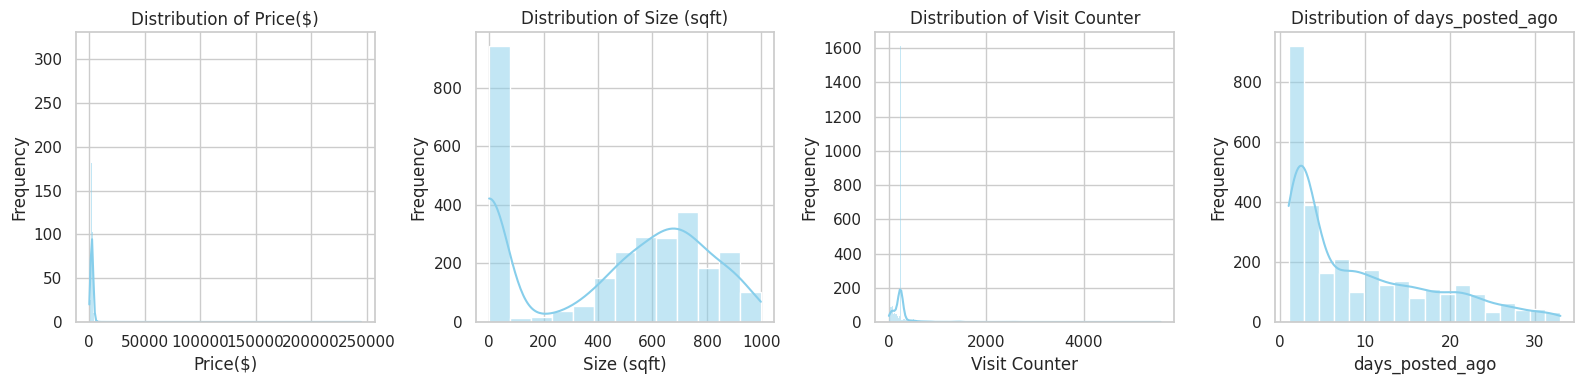

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

num_plots = len(numeric_columns)
# 4 columns per row
num_cols = min(4, num_plots)

num_rows = (num_plots - 1) // num_cols + 1

fig, axes = plt.subplots(1, num_cols, figsize=(4 * num_cols, 4))

# Iterate through numeric columns and plot each one
for i, col in enumerate(numeric_columns):
    ax = axes[i]

    sns.histplot(df[col], kde=True, ax=ax,color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Remove empty plots if exists
if num_plots < num_cols:
    for i in range(num_plots, num_cols):
        axes[i].remove()

plt.tight_layout()
plt.show()


**3.3 Univariate analysis**

**3.3.1 Bar chart**

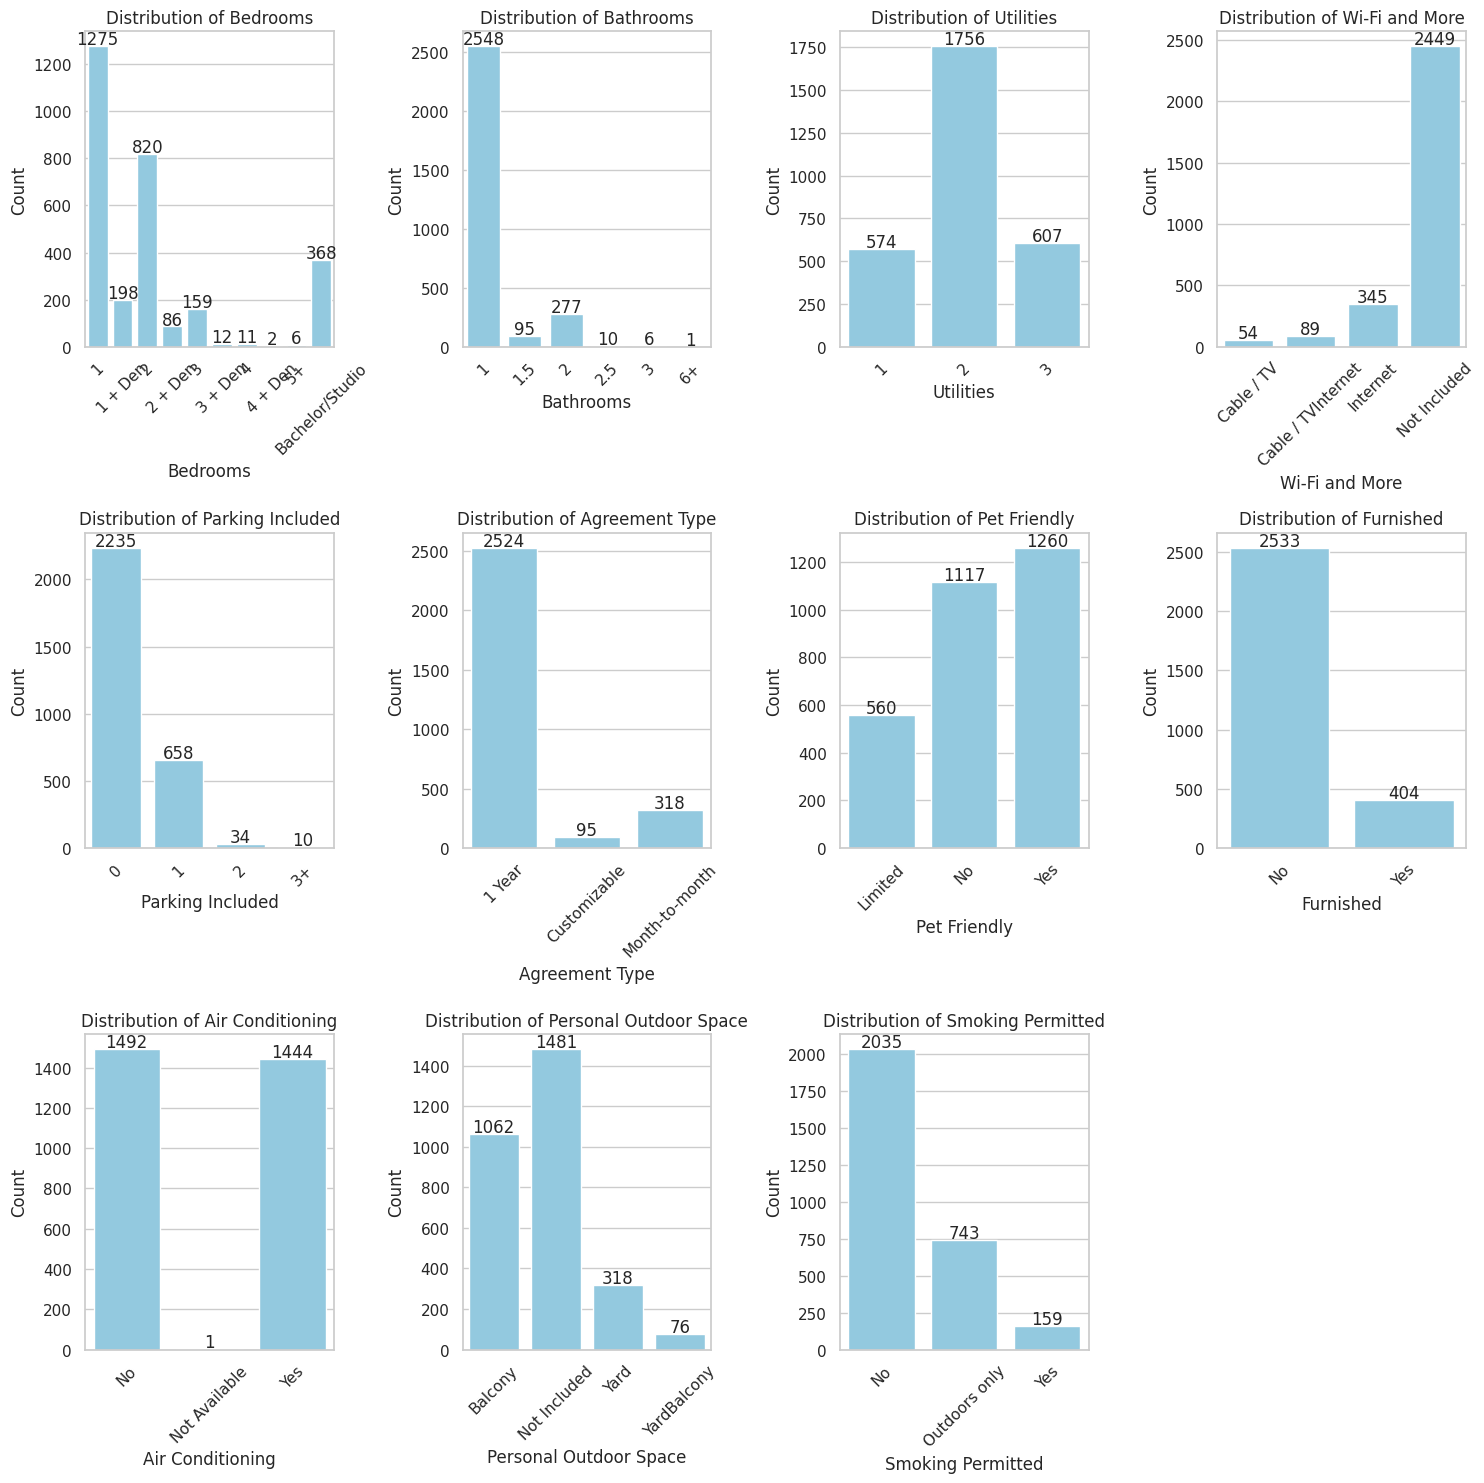

In [170]:
cols_for_plot = ['Bedrooms',
       'Bathrooms', 'Utilities', 'Wi-Fi and More', 'Parking Included',
       'Agreement Type', 'Pet Friendly', 'Furnished', 'Air Conditioning',
       'Personal Outdoor Space', 'Smoking Permitted']
cols_per_row = 4  # Number of columns per row
num_plots = len(cols_for_plot)
num_rows = (num_plots - 1) // cols_per_row + 1

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 5*num_rows))

# Iterate through columns and plot each one
for i, col in enumerate(cols_for_plot):
    row = i // cols_per_row
    col_idx = i % cols_per_row
    ax = axes[row] if num_rows == 1 else axes[row, col_idx]

    # Sort the data
    sorted_df = df[col].value_counts().sort_index().reset_index()

    sns.barplot(x='index', y=col, data=sorted_df, ax=ax,color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

    # Add count values on top of each bar
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 5),
                    textcoords = 'offset points')

# Remove empty subplots if necessary
if num_plots < num_rows * cols_per_row:
    for i in range(num_plots, num_rows * cols_per_row):
        axes.flat[i].set_visible(False)

plt.tight_layout()
plt.show()

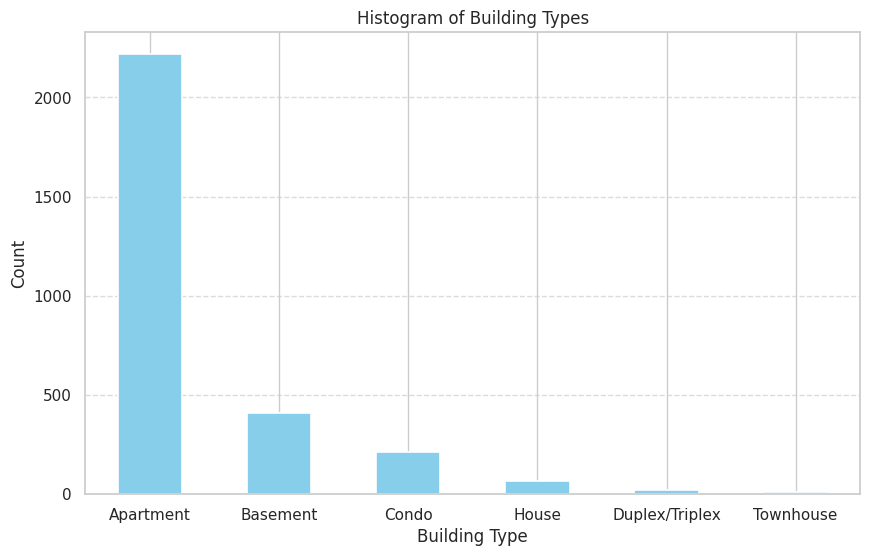

In [171]:
# Count the occurrences of each unique value in the 'Building Type' column
building_type_counts = df['Building Type'].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
building_type_counts.plot(kind='bar', color='skyblue', linewidth=1.2)

# Customize the plot
plt.title('Histogram of Building Types')
plt.xlabel('Building Type')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=360)

# Show plot
plt.show()

**3.3.2 Pie Chart**

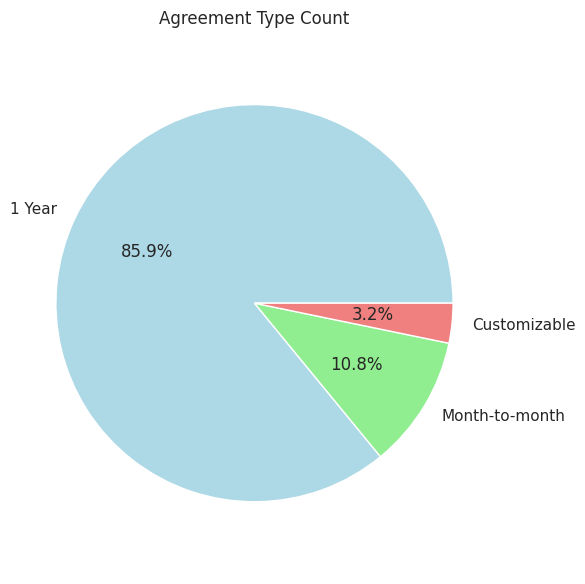

In [172]:
# Selecting a different column for the pie chart (e.g., 'Building Type')
column_name = 'Agreement Type'

# Counting the occurrences of each unique value in the selected column
column_count = df[column_name].value_counts()

# Plotting the pie chart
plt.figure(figsize=(6, 6))

# Define colors for the pie chart
colors = ['lightblue', 'lightgreen', 'lightcoral', 'orange', 'yellow']

plt.pie(column_count, labels=column_count.index, colors=colors, autopct='%1.1f%%')
plt.title(f'{column_name} Count')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()


**3.4 Bi-variate analysis**

**3.4.1 Bar Graph**

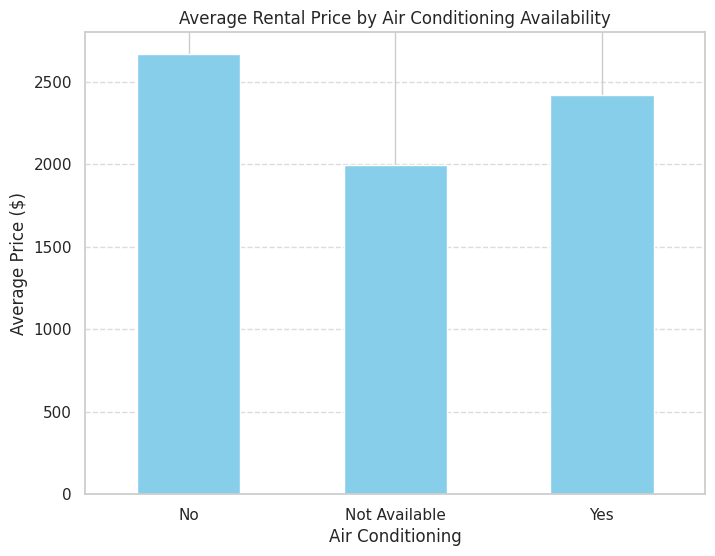

In [173]:
# Grouping data based on Air Conditioning availability and calculating average price
average_price_ac = df.groupby('Air Conditioning')['Price($)'].mean()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
average_price_ac.plot(kind='bar', color=['skyblue'])
plt.title('Average Rental Price by Air Conditioning Availability')
plt.xlabel('Air Conditioning')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


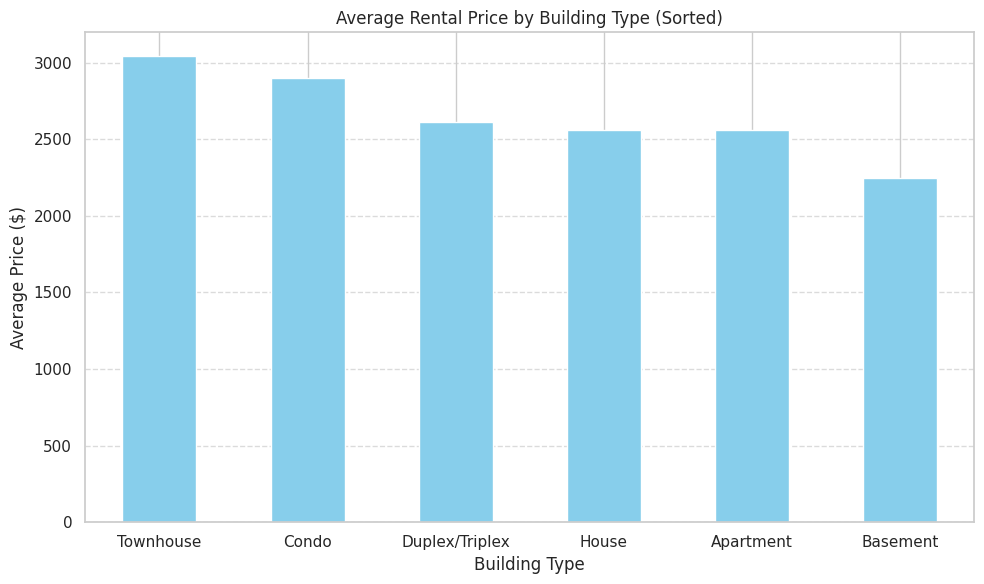

In [174]:

# Grouping data based on Building Type and calculating average price
average_price_building_type = df.groupby('Building Type')['Price($)'].mean()

# Sorting the average prices in descending order
average_price_building_type_sorted = average_price_building_type.sort_values(ascending=False)

# Plotting the sorted bar plot
plt.figure(figsize=(10, 6))
average_price_building_type_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Rental Price by Building Type (Sorted)')
plt.xlabel('Building Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()



<Figure size 1000x600 with 0 Axes>

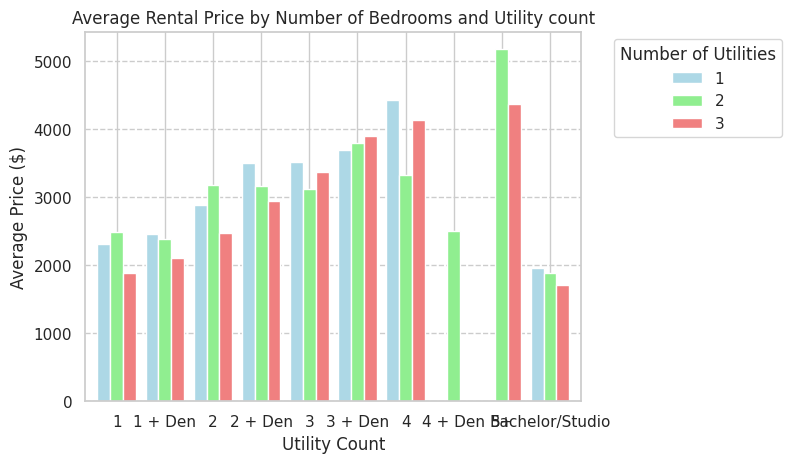

In [175]:


# Grouping data based on 'Pet Friendly' and 'Building Type', and calculating average price
average_price_pet_building = df.groupby(['Bedrooms','Utilities'])['Price($)'].mean().unstack()

# Plotting the grouped bar plot
plt.figure(figsize=(10, 6))
ax = average_price_pet_building.plot(kind='bar', color = ['lightblue', 'lightgreen', 'lightcoral'], width=0.8)
plt.title('Average Rental Price by Number of Bedrooms and Utility count')
plt.xlabel('Utility Count')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# Adjusting legend position
plt.legend(title='Number of Utilities', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.99)
plt.show()

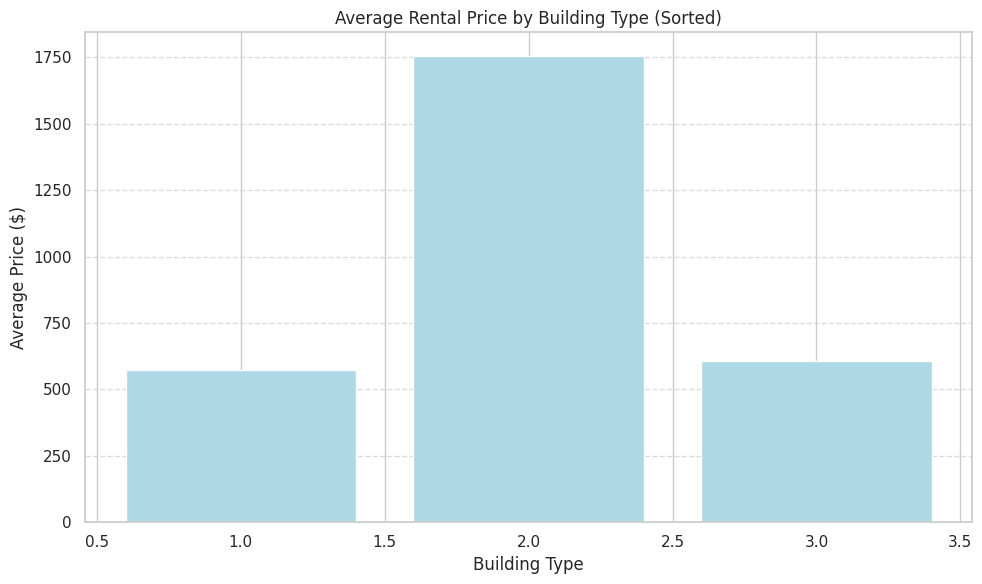

In [176]:

# Grouping data based on Building Type and calculating average price
utility_count = df['Utilities'].value_counts()

# Plotting the sorted bar plot
plt.figure(figsize=(10, 6))
plt.bar(utility_count.index, utility_count, color='lightblue')
plt.title('Average Rental Price by Building Type (Sorted)')
plt.xlabel('Building Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()



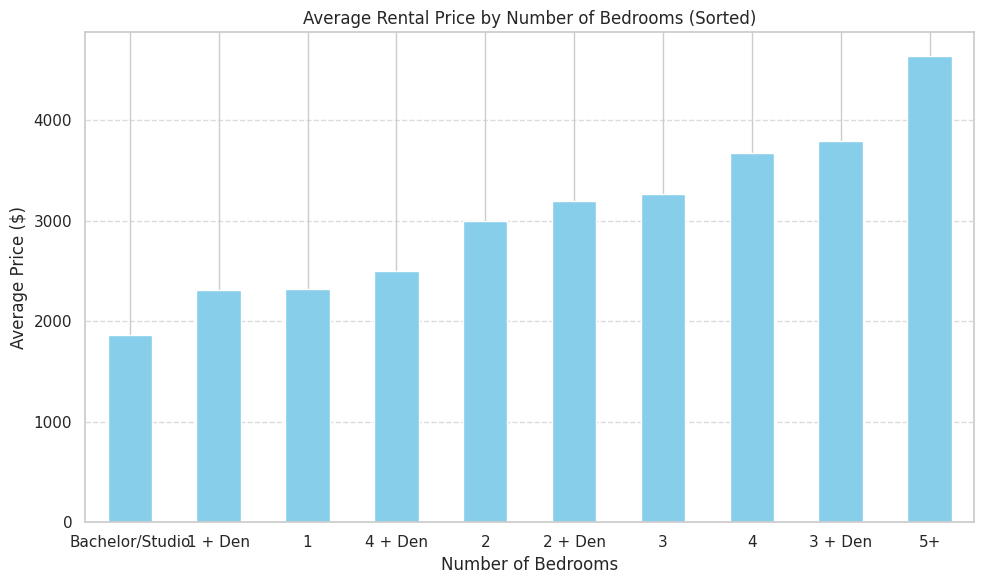

In [177]:


# Grouping data based on number of bedrooms and calculating average price
average_price_bedrooms = df.groupby('Bedrooms')['Price($)'].mean()

# Sorting the average prices in ascending order
average_price_bedrooms_sorted = average_price_bedrooms.sort_values()

# Plotting the sorted bar plot
plt.figure(figsize=(10, 6))
average_price_bedrooms_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Rental Price by Number of Bedrooms (Sorted)')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


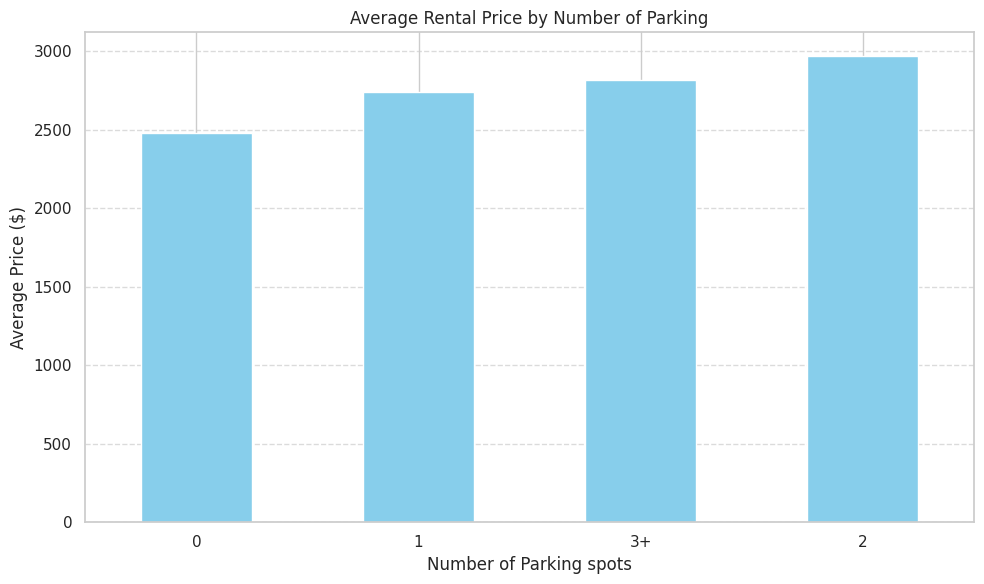

In [178]:

# Grouping data based on number of bedrooms and calculating average price
average_price_parking = df.groupby('Parking Included')['Price($)'].mean()

# Sorting the average prices in ascending order
average_price_parking_sorted = average_price_parking.sort_values()

# Plotting the sorted bar plot
plt.figure(figsize=(10, 6))
average_price_parking_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Rental Price by Number of Parking')
plt.xlabel('Number of Parking spots')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

<Figure size 46000x15000 with 0 Axes>

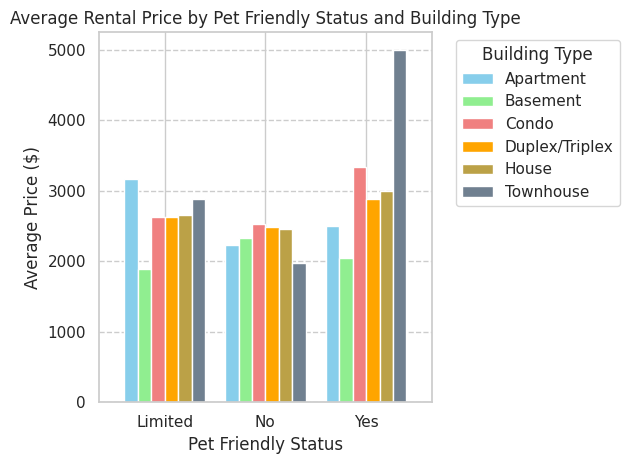

In [179]:
# Grouping data based on 'Pet Friendly' and 'Building Type', and calculating average price
average_price_pet_building = df.groupby(['Pet Friendly', 'Building Type'])['Price($)'].mean().unstack()

# Plotting the grouped bar plot
plt.figure(figsize=(460, 150))
ax = average_price_pet_building.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral', 'orange', '#bba147', '#708090'], width=0.8)
plt.title('Average Rental Price by Pet Friendly Status and Building Type')
plt.xlabel('Pet Friendly Status')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# Adjusting legend position
plt.legend(title='Building Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.99)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


**3.4.2 Scatter Plot**

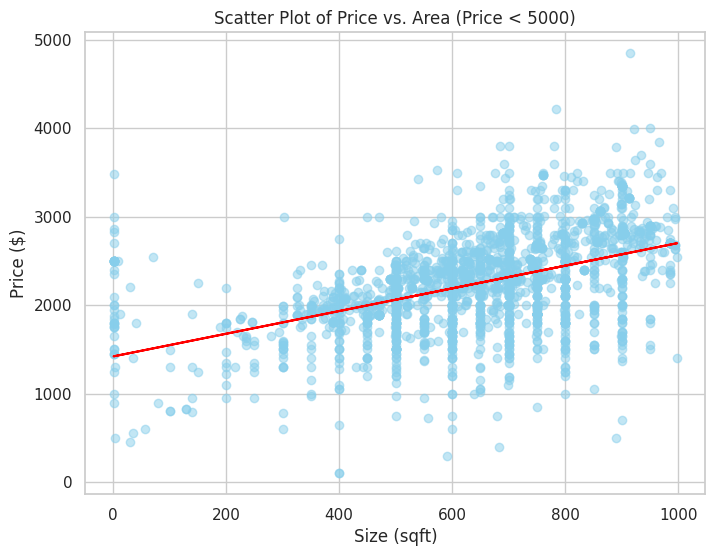

In [180]:
import matplotlib.pyplot as plt

# Filter out data where price is less than 5000
filtered_df = df[(df['Price($)'] < 5000) & (df['Size (sqft)'] > 0)]

# Create scatter plot with filtered data
plt.figure(figsize=(8, 6))
plt.scatter(filtered_df['Size (sqft)'], filtered_df['Price($)'], alpha=0.5, color= 'skyblue')
plt.title('Scatter Plot of Price vs. Area (Price < 5000)')
plt.xlabel('Size (sqft)')
plt.ylabel('Price ($)')

# Fit a linear regression line
x = filtered_df['Size (sqft)']
y = filtered_df['Price($)']
m, b = np.polyfit(x, y, 1)  # Fit a first degree polynomial (linear regression)
plt.plot(x, m*x + b, color='red')  # Plot the regression line

plt.show()



Observation:
Size in Square feet has positive correlation with Price. The red line represents positive correlation between these 2 variables.

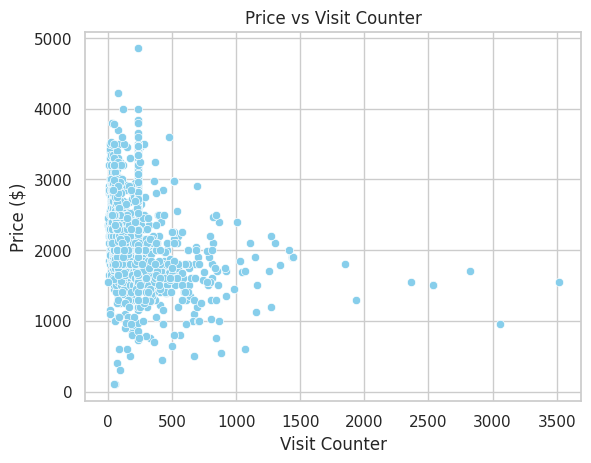

In [181]:
# Scatter plot for 'Price($)' vs 'Visit Counter'
sns.scatterplot(x='Visit Counter', y='Price($)', data=filtered_df, color = 'skyblue')
plt.title('Price vs Visit Counter')
plt.xlabel('Visit Counter')
plt.ylabel('Price ($)')
plt.show()

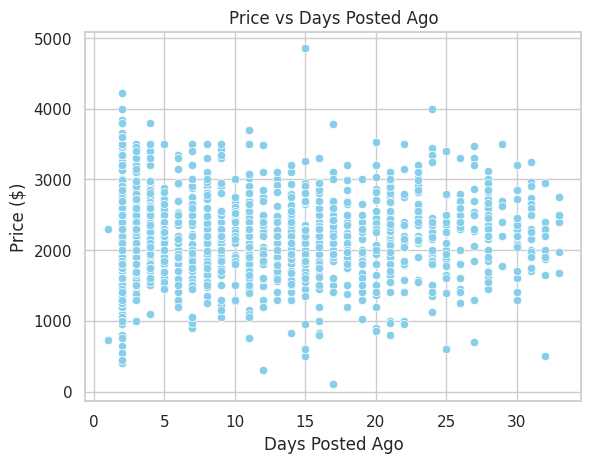

In [182]:
# Scatter plot for 'Price($)' vs 'days_posted_ago'
sns.scatterplot(x='days_posted_ago', y='Price($)', data=filtered_df, color= 'skyblue')
plt.title('Price vs Days Posted Ago')
plt.xlabel('Days Posted Ago')
plt.ylabel('Price ($)')
plt.show()

Step 4: pandas profiling is one of the useful tools you can use for exploratory data analysis (EDA) in future projects at work! Learning pandas profiling is a quite helpful for your future career. Please use the following link and use pandas profiling and generate a report in .html format (submit that along with your codes and pdf report)

## Step 4: Using Pandas Profiling for EDA

In [183]:
!pip install ydata-profiling

In [184]:
from ydata_profiling import ProfileReport

In [185]:
profile = ProfileReport(df, title="Profiling Report")

In [186]:
profile.to_file('pandas_profiling.html')

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Step 5: Data encoding for categorical columns

5.1 Custom Encoding methods based on scenario

In [213]:
# custom method for converting categorical columns to numeric columns based on
# context of data
def convert_bedroom_value(value):
    # Check if the value is already numeric or a string
    if pd.notnull(value):
        # Process non-numeric string values
        if value == 'Bachelor/Studio':
            num_bedrooms = 1
        elif '+' in value:
            parts = value.split('+')
            num_bedrooms = float(parts[0])
        else:
            num_bedrooms = float(value)
        return num_bedrooms
    else:
        # Return 0 for non-string or already numeric values
        return 0


def remove_plus(value):
     # Check if the value is None or NaN
    if pd.isna(value):
        return np.nan

    # If not a float and not NaN, remove the '+' sign using regular expressions and convert to float
    return float(re.sub(r'\+', '', str(value)))

def convert_to_numeric(value):
    if pd.isna(value):
        return np.nan
    elif value == 'Yes':
        return 1
    elif value == 'No':
        return 0
    elif value == 'Limited' or value == 'Outdoors only':
        return 0.5
    elif value == 'Not Available':
        return 0
    else:
        return value


In [ ]:
# Convert the 'Bedrooms' column to numeric
df['Bedrooms'] = pd.to_numeric(df['Bedrooms'].apply(convert_bedroom_value))
# Convert the 'Bedrooms' column to numeric
df['Bathrooms'] = pd.to_numeric(df['Bathrooms'].apply(remove_plus))
# Convert the 'Bedrooms' column to numeric
df['Parking Included'] = pd.to_numeric(df['Parking Included'].apply(remove_plus))


In [188]:
df['Pet Friendly'] = pd.to_numeric(df['Pet Friendly'].apply(convert_to_numeric))
df['Air Conditioning'] = pd.to_numeric(df['Air Conditioning'].apply(convert_to_numeric))
df['Smoking Permitted'] = pd.to_numeric(df['Smoking Permitted'].apply(convert_to_numeric))

In [189]:
# df.head()
df['Bathrooms'].value_counts()

1.0    2548
2.0     277
1.5      95
2.5      10
3.0       6
6.0       1
Name: Bathrooms, dtype: int64

In [190]:
# find categorical and numerical columns after data encoding
numeric_columns = df.select_dtypes(include=np.number).columns
categorical_columns = df.select_dtypes(exclude=np.number).columns

In [191]:
print(numeric_columns)
print(categorical_columns)

Index(['Price($)', 'Bedrooms', 'Bathrooms', 'Parking Included', 'Pet Friendly',
       'Size (sqft)', 'Air Conditioning', 'Smoking Permitted', 'Visit Counter',
       'days_posted_ago'],
      dtype='object')
Index(['Title', 'Address', 'Date Posted', 'Building Type', 'Utilities',
       'Wi-Fi and More', 'Agreement Type', 'Furnished',
       'Personal Outdoor Space', 'Description', 'url'],
      dtype='object')


In [192]:
df.shape

(2937, 21)

5.2 Label Encoding

For columns which we can rank numerically , we are using Label encoding. Furnished Apartment are ranked higher than Unfurnished ones so we are using Lable encoder on Furnished column.

In [193]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to your categorical column and transform it
encoded_labels = label_encoder.fit_transform(df['Furnished'])

# Replace the original column with the encoded labels
df['Furnished'] = encoded_labels


In [194]:
df.head()

,Title,Price($),Address,Date Posted,Building Type,Bedrooms,Bathrooms,Utilities,Wi-Fi and More,Parking Included,...,Pet Friendly,Size (sqft),Furnished,Air Conditioning,Personal Outdoor Space,Smoking Permitted,Description,Visit Counter,url,days_posted_ago
0,6020 Bathurst Street - Valencia Towers Apartme...,3209.0,"6020 Bathurst Street, Toronto, ON, M2R 1Z8",2024-02-24 23:30:00,Apartment,2.0,1.0,2,Not Included,0.0,...,1.0,912.0,0,0,Not Included,0.0,Valencia Towers is a student- and family-frien...,238,https://www.kijiji.ca/v-apartments-condos/city...,20
1,RENOVATED BACHELOR SUITE AVAILABLE! Lakeview ...,2000.0,"22 Close Avenue, Toronto, ON, M6K 2V2",2024-03-14 00:09:49,Apartment,1.0,1.0,1,Not Included,0.0,...,1.0,445.0,0,0,Balcony,0.0,"Bachelors, 1 Bath, Recently Renovated Kitchen ...",238,https://www.kijiji.ca/v-apartments-condos/city...,2
2,50 Driftwood - Ruby Heights Apartment for Rent,2819.0,"50 Driftwood, Toronto, ON, M3N 2M6",2024-03-03 00:08:58,Apartment,2.0,1.0,2,Not Included,0.0,...,1.0,904.0,0,0,Not Included,0.0,"Ruby Heights, located in the North York distri...",238,https://www.kijiji.ca/v-apartments-condos/city...,13
3,1 Bed Apartment Rent today,2519.0,"100 Parkway Forest Drive, Toronto, ON, M2J 1L6",2024-03-06 00:35:06,Apartment,1.0,1.0,2,Not Included,0.0,...,0.5,665.0,0,0,Yard,1.0,"For a limited time, you can receive ONE MONTH ...",238,https://www.kijiji.ca/v-apartments-condos/city...,10
4,Brand New 2-bedroom Rental in North York! Yor...,2690.0,"1225 York Road, Toronto, ON, M3A 1Y4",2024-03-04 00:39:41,Apartment,2.0,1.0,2,Not Included,0.0,...,1.0,0.0,0,1,Balcony,1.0,Realstar's ONE225 York Mills is North Yorks ne...,238,https://www.kijiji.ca/v-apartments-condos/city...,12


5.3 One Hot Encoding (OHE)

For certain categorical columns such as Building type and personal outdoor space, we cannot rank them. We are using OHE to encode such columns for further analysis

In [195]:
from sklearn.preprocessing import OneHotEncoder

# Define the columns to be one-hot encoded
columns_to_encode = ['Personal Outdoor Space', 'Building Type']

# Create an instance of OneHotEncoder
onehot_encoder = OneHotEncoder()

# Fit the encoder to the selected columns and transform them
onehot_encoded = onehot_encoder.fit_transform(df[columns_to_encode])

# Convert the sparse matrix to a DataFrame
onehot_encoded_df = pd.DataFrame(onehot_encoded.toarray(), columns=onehot_encoder.get_feature_names_out(columns_to_encode))

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df = pd.concat([df, onehot_encoded_df], axis=1)

# Drop the original categorical columns if needed
df.drop(columns_to_encode, axis=1, inplace=True)


In [196]:
df.shape

(3702, 29)

Step 6: use proper techniques (boxplots AND IQR) to identify the outliers on each column (attribute) and explain your approach/results.

## Step 6: Outlier Detection

In [197]:
def generate_box_plot(df, column, handled_outliers = False):
  sns.set(style="whitegrid")

  plt.figure(figsize=(8, 6))
  sns.boxplot(y=filtered_df[column], orient='v', color='skyblue')
  title = 'Boxplot of '+column + (' after' if handled_outliers else ' before') + ' outlier handling'
  plt.title(title)
  plt.ylabel(column)
  plt.show()

def generate_histogram(df, column, handled_outliers = False):
  plt.hist(data, bins=10)
  title = 'Histogram of '+column + (' after' if handled_outliers else ' before') + ' outlier handling'
  plt.title(title)
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.show()

def generate_plots(df, column, handled_outliers=False):
    # Set up the figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    title = ' of '+column + (' after' if handled_outliers else ' before') + ' outlier handling'

    # boxplot
    sns.boxplot(y=df[column], orient='v', color='skyblue', ax=axes[0], showfliers=False)
    axes[0].set_title('Boxplot '+ title)
    axes[0].set_ylabel(column)

    # histogram
    axes[1].hist(df[column], bins=100,color='skyblue')
    axes[1].set_title('Histogram '+ title)
    axes[1].set_xlabel('Values')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


**6.1 Interquartile Range (IQR)**

In [198]:
import numpy as np

# Define a function for outlier detection using IQR
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, Q1, Q3, IQR

print("Outliers in number")
for n_c in numeric_columns:
  outliers,Q1, Q3, IQR = detect_outliers_iqr(df[n_c])

  # Print number of outliers
  print(f"{n_c} : {outliers.sum()} (Q1: {Q1}, Q3: {Q3}, IQR: {IQR})")




Outliers in number
Price($) : 0 (Q1: nan, Q3: nan, IQR: nan)
Bedrooms : 0 (Q1: nan, Q3: nan, IQR: nan)
Bathrooms : 0 (Q1: nan, Q3: nan, IQR: nan)
Parking Included : 0 (Q1: nan, Q3: nan, IQR: nan)
Pet Friendly : 0 (Q1: nan, Q3: nan, IQR: nan)
Size (sqft) : 0 (Q1: nan, Q3: nan, IQR: nan)
Air Conditioning : 0 (Q1: nan, Q3: nan, IQR: nan)
Smoking Permitted : 0 (Q1: nan, Q3: nan, IQR: nan)
Visit Counter : 0 (Q1: nan, Q3: nan, IQR: nan)
days_posted_ago : 0 (Q1: nan, Q3: nan, IQR: nan)


**Observation**

Most of the columns doesnot have outliers because they are converted to numerical variable from categorical and they falls in very small data range.
Columns which were numeric on scrapping(Price,Visitor count) are likely to have more outliers.

In [199]:
# define columns with outlier to use in outlier handling
outlier_columns = ['Price($)','Visit Counter']

**6.2 Box-plots**

Step 7: use all the following techniques to address the outliers and explain/discuss the differences in the outcome of each of the methods
	Quantile-based Flooring and Capping
	Trimming
	Log Transformation


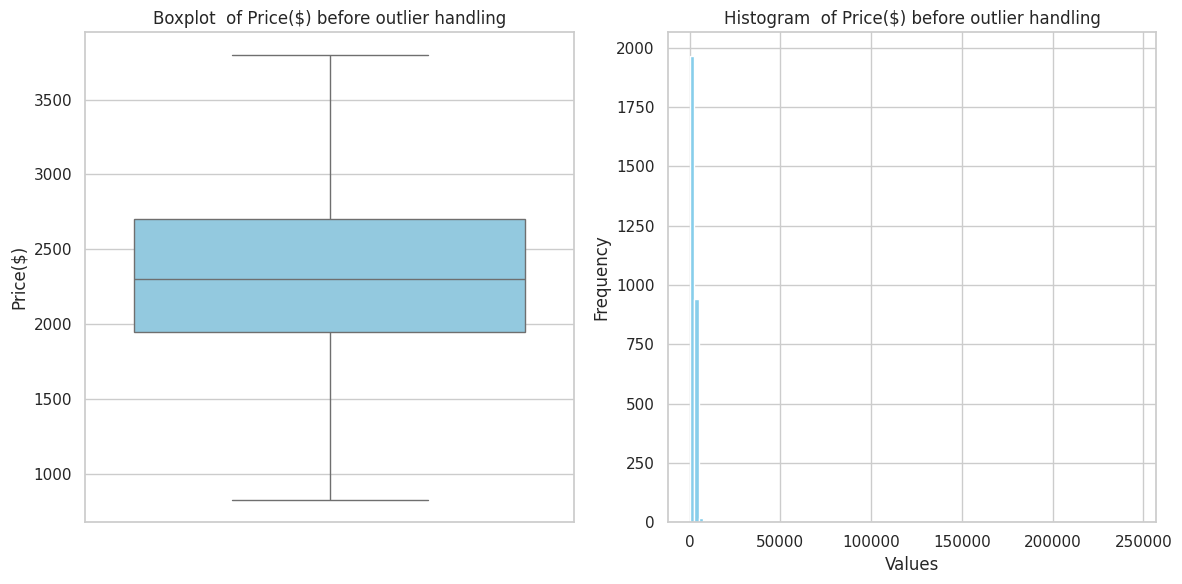

In [200]:
generate_plots(df,'Price($)')

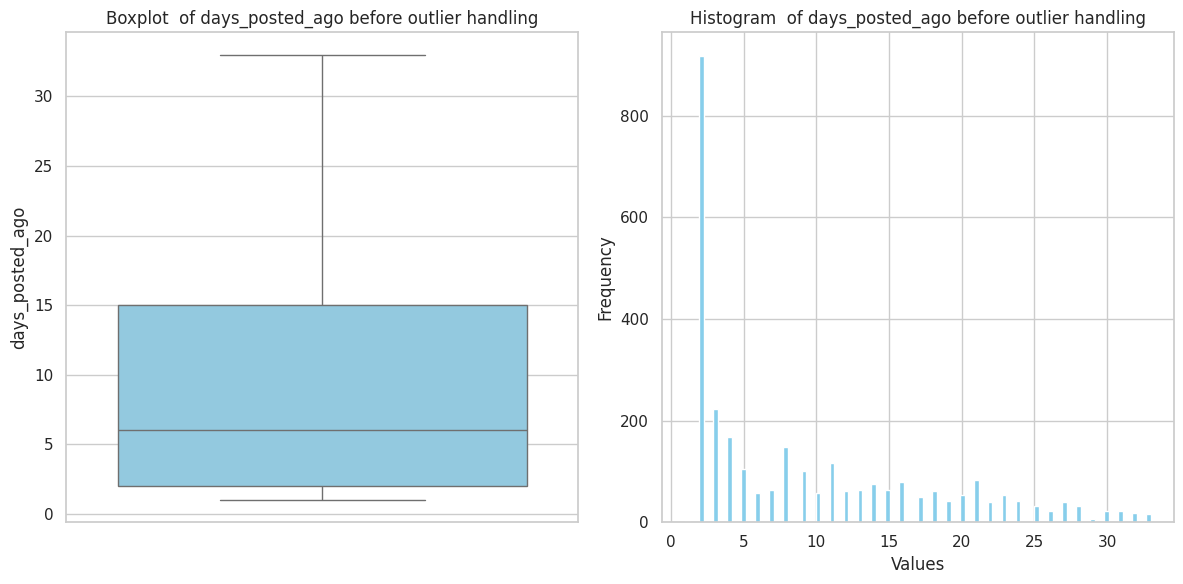

In [201]:
generate_plots(df,'days_posted_ago')

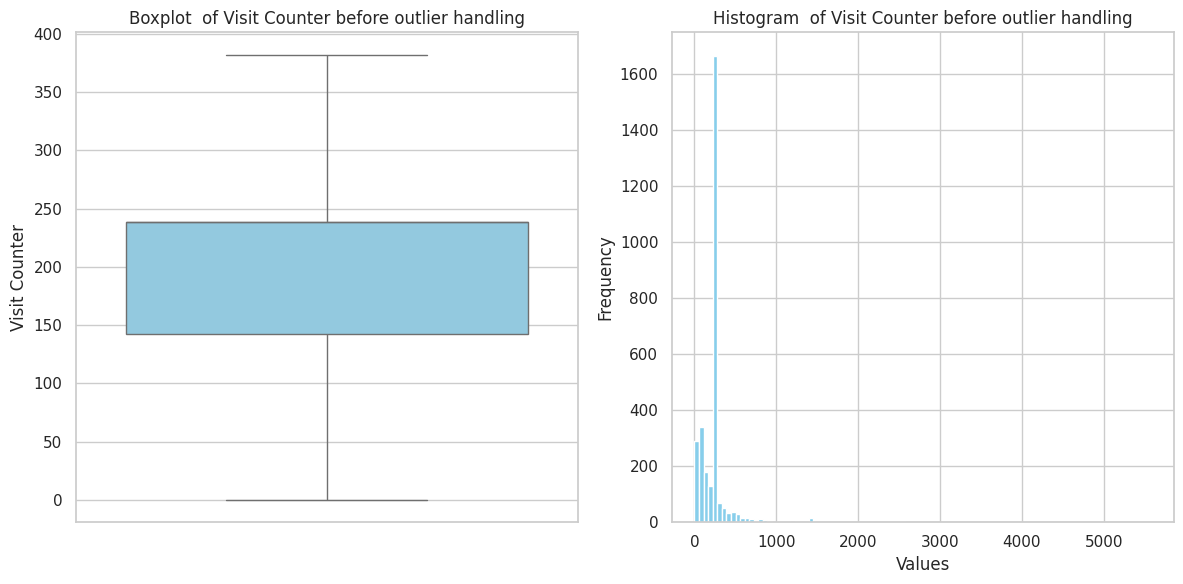

In [202]:
generate_plots(df,'Visit Counter')

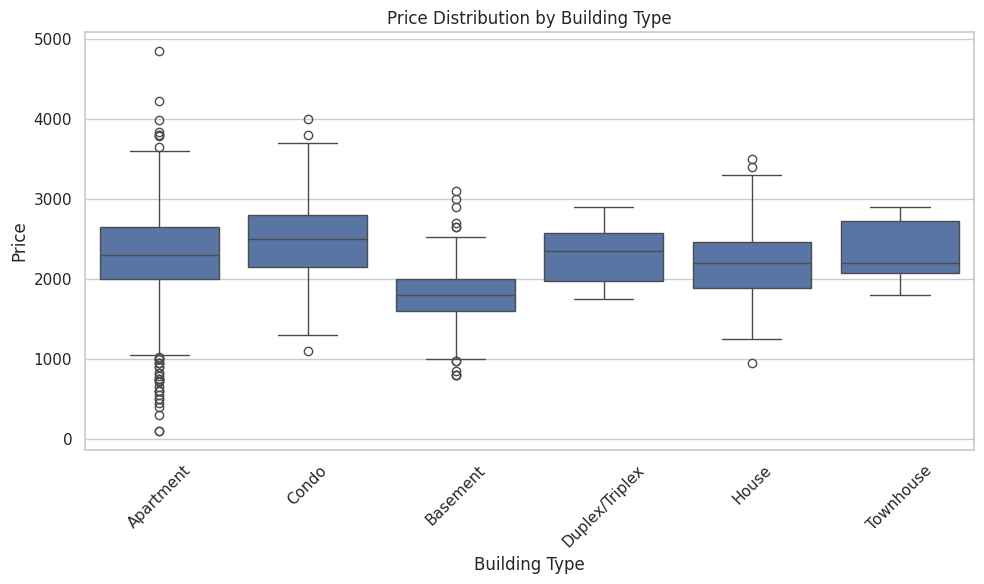

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns  # For improved aesthetics

# Assuming df is your DataFrame
# Make sure 'Building Type' and 'Price' columns exist in your DataFrame

# Set the style for seaborn
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 6))  # Adjust the size of the plot if necessary
sns.boxplot(x='Building Type', y='Price($)', data=filtered_df)

# Add title and labels
plt.title('Price Distribution by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Price')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


## Step 7: Outlier Treatment

**7.1 Quantile based Flooring and Capping**

In [204]:
def quantile_flooring_and_capping(df, columns_to_process, floor_quantile=0.1, cap_quantile=0.9):
    # copy the dataframe to avoid modifying original
    df_processed = df.copy()

    # Iterate over each column to process
    for column in columns_to_process:
        # Calculate thresholds for flooring and capping
        floor_threshold = df_processed[column].quantile(floor_quantile)
        cap_threshold = df_processed[column].quantile(cap_quantile)

        # Floor values below the floor threshold
        df_processed[column] = df_processed[column].apply(lambda x: floor_threshold if x < floor_threshold else x)

        # Cap values above the cap threshold
        df_processed[column] = df_processed[column].apply(lambda x: cap_threshold if x > cap_threshold else x)

    return df_processed

In [205]:
df_flooring_and_capping = quantile_flooring_and_capping(df, outlier_columns)

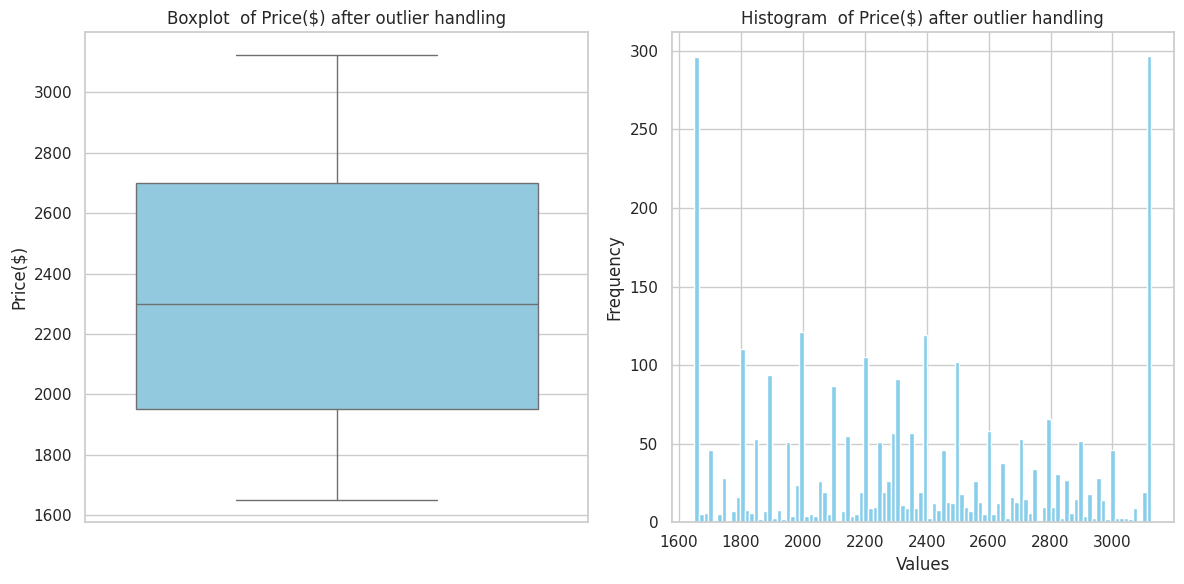

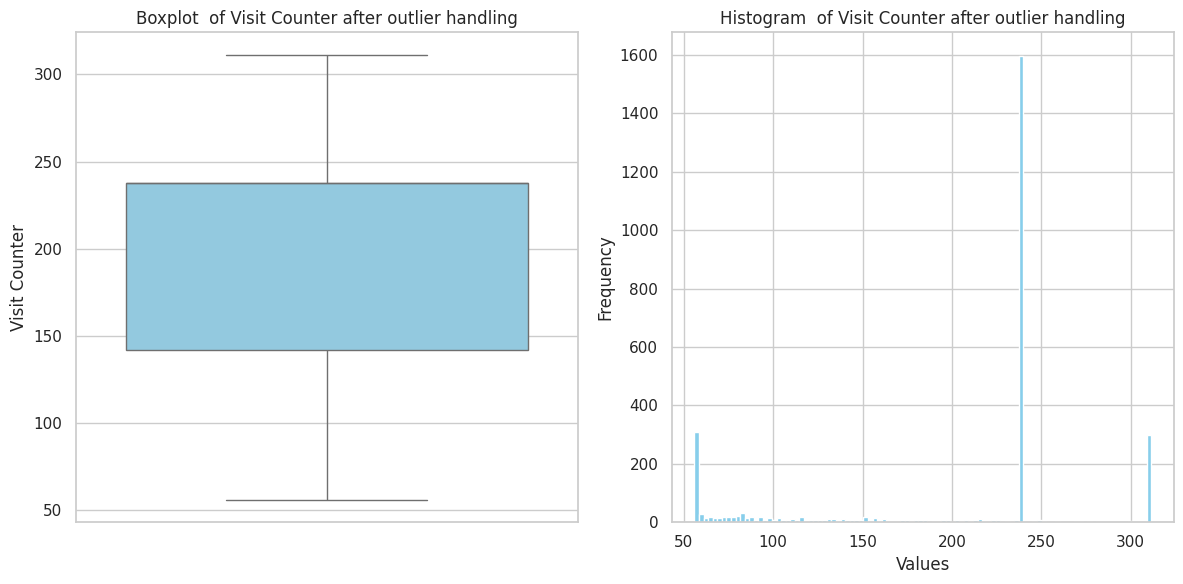

In [206]:
for col in outlier_columns:
  generate_plots(df_flooring_and_capping,col, True)

**Observation**

Flooring and capping has given better result for Price and Visitoe count but for Days count remaining it has shown minor impact only

**7.2 Trimming**

In [207]:
def trimming(df, columns_to_process, trim_lower=0.1, trim_upper=0.9):
    # copy the dataframe to avoid modifying original
    df_trimmed = df.copy()


    # Iterate over each column to process
    for column in columns_to_process:
        # Calculate lower and upper trim thresholds
        lower_threshold = df_trimmed[column].quantile(trim_lower)
        upper_threshold = df_trimmed[column].quantile(trim_upper)

        # Remove outliers by trimming
        df_trimmed = df_trimmed[(df_trimmed[column] >= lower_threshold) & (df_trimmed[column] <= upper_threshold)]

    return df_trimmed

In [208]:
df_trimmed = trimming(df, outlier_columns)

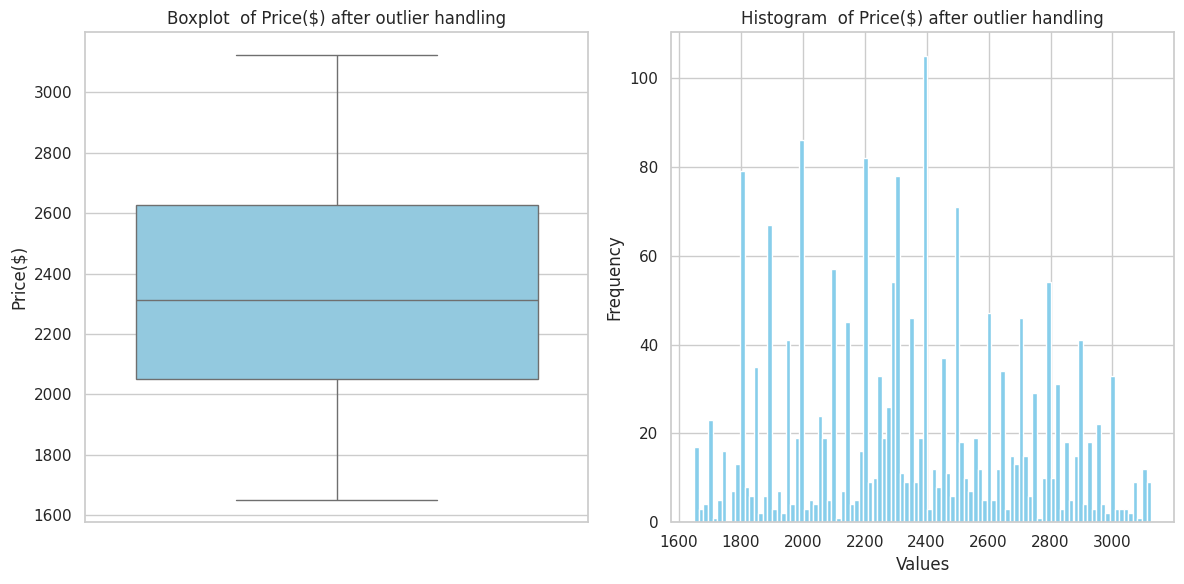

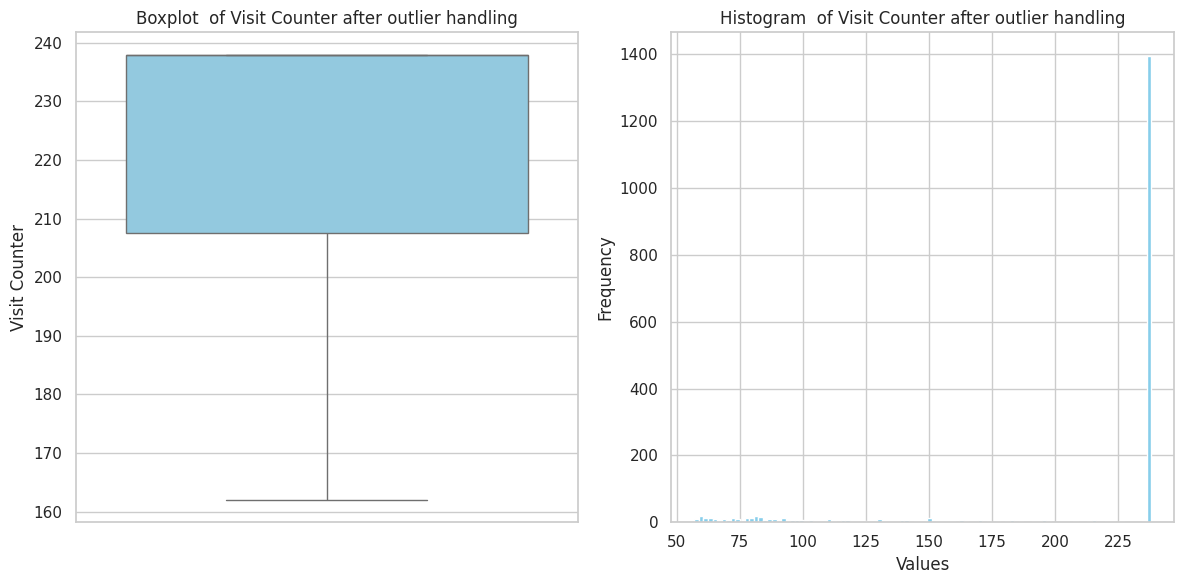

In [209]:
for col in outlier_columns:
  generate_plots(df_trimmed,col, True)

Observation

7.3 Log Transformation

In [210]:
import numpy as np

def log_transform(df, column):
    # Make a copy of the DataFrame to avoid modifying the original data
    df_log_transformed = df.copy()

    # Apply log transformation to the specified column
    df_log_transformed[column] = np.log(df_log_transformed[column])

    return df_log_transformed


In [211]:
df_log = log_transform(df, outlier_columns)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


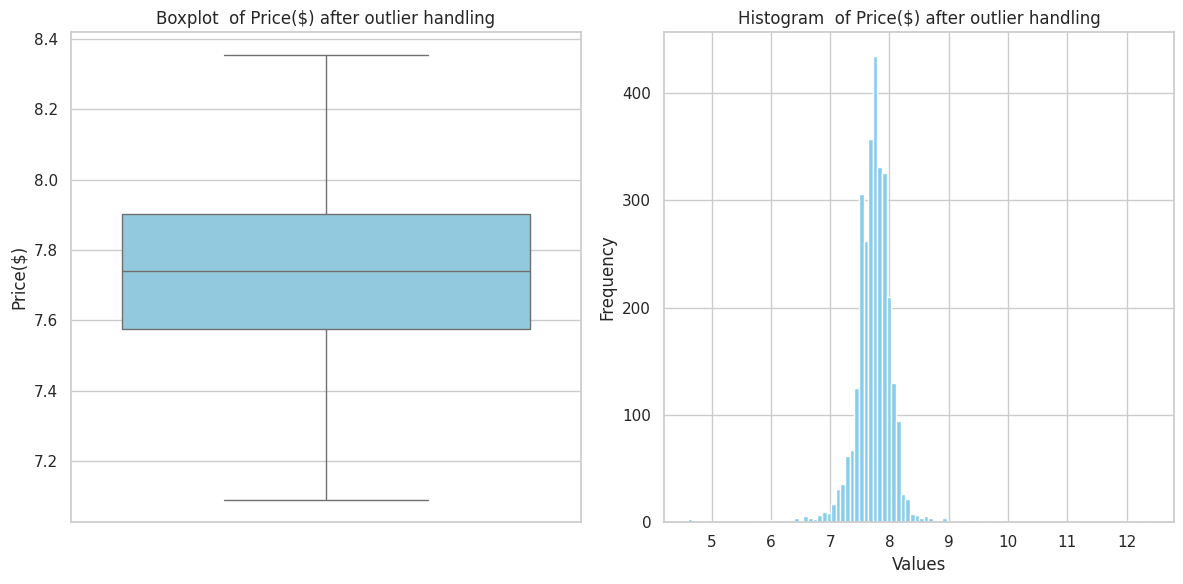

ValueError: supplied range of [-inf, 8.626944055375356] is not finite

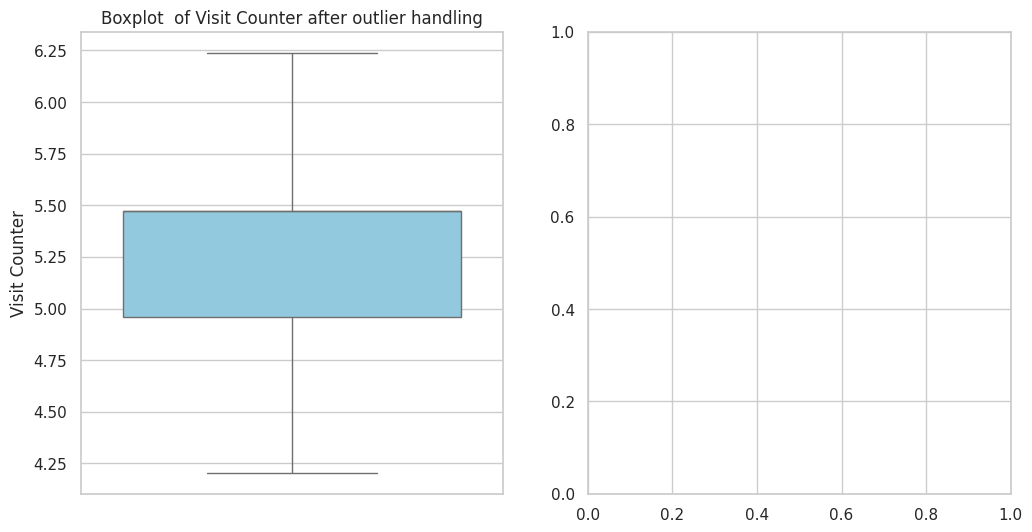

In [212]:
for col in outlier_columns:
  generate_plots(df_log,col, True)

Step 8: Use the unsupervised learning method of your choice (e.g: K-Means ) on the data you have for this assignment and discuss the outcomes. (at least 2 methods to be used and discussed)

## Step 8: Using Unsupervised Learning method

In [ ]:
if (df['Price($)'] < 0).any():
    print("The 'Visit Counter' column contains negative values.")
else:
    print("The 'Visit Counter' column does not contain negative values.")

In [ ]:
selected_columns = ['Price($)', 'Bedrooms', 'Bathrooms', 'Size (sqft)']

# Check for null values in the selected columns
null_counts = df[selected_columns].isnull().sum()

# Print the columns with null values
columns_with_null = null_counts[null_counts > 0].index.tolist()
print("Columns with null values:", columns_with_null)

# Print the count of null values in each column
for column in columns_with_null:
    print(f"{column}: {null_counts[column]} null values")


In [ ]:
# Find rows with null values in the selected columns
rows_with_null = df[selected_columns].isnull().any(axis=1)

# Print a sample of rows with null values
print(df[rows_with_null].head())

In [ ]:
def count_non_null_rows(df):
    """
    Count the number of rows in a DataFrame where there are no null values.

    Parameters:
        df (DataFrame): The input DataFrame.

    Returns:
        int: The number of rows with no null values.
    """
    non_null_rows = df.dropna()
    return len(non_null_rows)

# Example usage:
non_null_count = count_non_null_rows(df)
print("Number of rows with no null values:", non_null_count)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


selected_columns = ['Price($)', 'Bedrooms', 'Bathrooms', 'Size (sqft)']
data = df[selected_columns]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Choose the number of clusters (k)
k = 3

# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)

# Get cluster labels and assign them back to the DataFrame
df['Cluster'] = kmeans.labels_

# Analyze clusters
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i+1} Center: {center}")

# Visualize clusters if possible
# Example: Scatter plot of two features with cluster labels
import matplotlib.pyplot as plt
plt.scatter(df['Price($)'], df['Size (sqft)'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Price ($)')
plt.ylabel('Size (sqft)')
plt.title('K-Means Clustering of Rental Listings')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the data

# Step 1: Data Preprocessing (Handling missing values, encoding categorical variables, etc.)

# Step 2: Feature Selection (Select relevant features for clustering)

# Step 3: Determine the number of clusters (K)
# For example, using the elbow method to find the optimal number of clusters

# Inertia values for different number of clusters
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Based on the elbow method, select the optimal number of clusters

# Step 4: Apply K-Means clustering
# Assuming optimal number of clusters is determined as K

k = 4  # Example: Optimal number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df)

# Step 5: Interpret Results
# Analyze cluster centers and characteristics of each segment

# Visualize cluster centers (if applicable)
cluster_centers = kmeans.cluster_centers_

# Step 6: Evaluation (if applicable)
# Evaluate the quality of the clusters using metrics such as silhouette score

# Step 7: Discussion of Outcomes
# Discuss insights gained from cluster analysis and potential applications of segmentation results


Step 9 (Bonus mark): if your input includes txt data, please apply proper NLP techniques (data cleaning, stop word/punctuation removal, tokenizing, stemming/lemmatizing etc) and bonus mark might be granted.

## Step 9: Implementing NLP technique

Deliverables and submission instructions for this assignment:

- Only one person per team should submit the deliverables (same person should submit all the following parts:
- The python code in ipynb format including proper markdowns and explanations (submit into Moodle)
- The source data (this can be shared using your college one drive and sharing that with your instructor)
- Pandas profiling report in .html format (submit through Moodle or One drive)
- Complete professional report including graphs/tables etc and proper explanation of observations and conclusion (preferably ‘avoid’ including lots of code snapshot, please). Your pdf report should be under 15 pages and use college cover page and make sure to include the complete name and student number of all team members on the front page.
